# 实验2程序 (Lab2 Program)

Author: 高鹏昺

Email: nbgao@126.com

In [250]:
import numpy as np
import sklearn
import scipy.io as sio
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import feature as feature
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Load Data

In [2]:
# mnist = fetch_mldata('mnist-original', data_home = './data/') 
mnist = sio.loadmat('./data/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [25]:
data, label = mnist['data'].T, mnist['label'].T

print('data shape:', data.shape)
print('label shape:', label.shape)

data shape: (70000, 784)
label shape: (70000, 1)


In [38]:
img = np.zeros([len(data), 28, 28])
for i in range(0,len(data)):
    img[i] = data[i].reshape(28, 28)

(-0.5, 27.5, 27.5, -0.5)

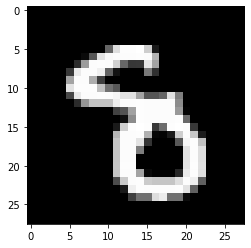

In [42]:
plt.imshow(img[50000], cmap='gray')
plt.axis()

## 2. Data Preprocess

训练集/测试集划分比例为6:1,即训练集60000,测试集10000

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=1/7, random_state=33)
print('data_train.shape:', data_train.shape)
print('data_test.shape:', data_test.shape)

data_train.shape: (60000, 784)
data_test.shape: (10000, 784)


In [216]:
standardScaler = StandardScaler()
data_train_ss = standardScaler.fit_transform(data_train)
data_test_ss = standardScaler.transform(data_test)

### Gray Level Histogram Feature

In [217]:
# 特征长度为256
feature_256 = np.zeros([len(data), 256])
feature_256.shape

(70000, 256)

In [218]:
for i in range(0,len(data)):
    for j in range(0, 256):
        #print(int((data_train[i]==j).sum()))
        feature_256[i][j] = int((data[i]==j).sum())

灰度直方图统计量(256级)

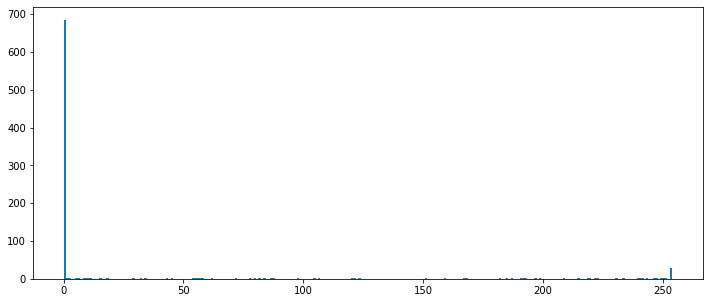

In [255]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.hist(data[10000], bins=256);

In [219]:
feature_256_train, feature_256_test, label_train, label_test = train_test_split(feature_256, label, test_size=1/7, random_state=33)
print('feature_256_train.shape:', feature_256_train.shape)
print('feature_256_test.shape:', feature_256_test.shape)

feature_256_train.shape: (60000, 256)
feature_256_test.shape: (10000, 256)


### LBP Feature

In [239]:
radius = 1
n_points = radius * 8
LBP_feature = np.zeros([len(data), 784])
for i in range(0,len(data)):
    LBP_feature[i] = feature.local_binary_pattern(img[i], n_points, radius, 'default').flatten()

LBP = np.zeros([len(data), 256])
for i in range(0,len(data)):
    for j in range(0, 256):
        #print(int((data_train[i]==j).sum()))
        LBP[i][j] = int((LBP_feature[i]==j).sum())

In [240]:
LBP_train, LBP_test, label_train, label_test = train_test_split(LBP, label, test_size=1/7, random_state=33)
print('LBP_train.shape:', LBP_train.shape)
print('LBP_test.shape:', LBP_test.shape)

LBP_train.shape: (60000, 256)
LBP_test.shape: (10000, 256)


### HOG Feature

In [ ]:
'''
def hog_feature(im):
  # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.atleast_2d(im)
        sx, sy = image.shape # image size
        orientations = 9 # number of gradient bins
        cx, cy = (2, 2) # pixels per cell
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        img_hog = ndimage.uniform_filter(temp_mag, size=(cx, cy))
        #print(img_hog)
        plt.imshow(img_hog, cmap='gray');
#         orientation_histogram[:,:,i] = ndimage.uniform_filter(temp_mag, size=(cx, cy))
#         orientation_histogram[:,:,i] = ndimage.uniform_filter(temp_mag, size=(cx, cy))[cx/2::cx, cy/2::cy].T
    
    return orientation_histogram.ravel()
'''

## 3. Model

In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

### 3.1 Decision Tree

#### Pixel

In [220]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(data_train_ss, label_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [221]:
# Predict
label_predict = decisionTree.predict(data_test_ss)

In [222]:
# Result Evaluation
print('The Accuracy of Decision Tree:', decisionTree.score(data_test_ss, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Decision Tree: 0.8748
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       957
         1.0       0.94      0.96      0.95      1113
         2.0       0.86      0.88      0.87      1040
         3.0       0.85      0.83      0.84      1012
         4.0       0.84      0.89      0.86       949
         5.0       0.85      0.84      0.84       940
         6.0       0.89      0.88      0.88      1006
         7.0       0.91      0.89      0.90      1014
         8.0       0.83      0.81      0.82       970
         9.0       0.85      0.83      0.84       999

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#### Gray_256

In [223]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(feature_256_train, label_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [224]:
# Predict
label_predict = decisionTree.predict(feature_256_test)

In [225]:
# Result Evaluation
print('The Accuracy of Decision Tree:', decisionTree.score(feature_256_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Decision Tree: 0.2595
              precision    recall  f1-score   support

         0.0       0.28      0.31      0.30       957
         1.0       0.89      0.88      0.89      1113
         2.0       0.14      0.13      0.14      1040
         3.0       0.14      0.14      0.14      1012
         4.0       0.17      0.17      0.17       949
         5.0       0.12      0.11      0.12       940
         6.0       0.12      0.12      0.12      1006
         7.0       0.27      0.28      0.27      1014
         8.0       0.21      0.20      0.20       970
         9.0       0.16      0.16      0.16       999

    accuracy                           0.26     10000
   macro avg       0.25      0.25      0.25     10000
weighted avg       0.26      0.26      0.26     10000



#### LBP

In [241]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(LBP_train, label_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [242]:
# Predict
label_predict = decisionTree.predict(LBP_test)

In [243]:
# Result Evaluation
print('The Accuracy of Decision Tree:', decisionTree.score(LBP_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Decision Tree: 0.4884
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52       957
         1.0       0.92      0.94      0.93      1113
         2.0       0.28      0.27      0.28      1040
         3.0       0.50      0.51      0.50      1012
         4.0       0.47      0.49      0.48       949
         5.0       0.44      0.42      0.43       940
         6.0       0.30      0.31      0.31      1006
         7.0       0.58      0.59      0.59      1014
         8.0       0.41      0.38      0.40       970
         9.0       0.38      0.40      0.39       999

    accuracy                           0.49     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.49      0.49      0.49     10000



### 3.2  Logistic Regression

#### Pixel

In [227]:
logisticRegression = LogisticRegression()
logisticRegression.fit(data_train_ss, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [228]:
# Predict
label_predict = logisticRegression.predict(data_test_ss)

In [229]:
# Result Evaluation
print('The Accuracy of Logistic Regression:', logisticRegression.score(data_test_ss, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Logistic Regression: 0.9125
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       957
         1.0       0.94      0.98      0.96      1113
         2.0       0.92      0.89      0.91      1040
         3.0       0.91      0.88      0.89      1012
         4.0       0.89      0.93      0.91       949
         5.0       0.90      0.85      0.88       940
         6.0       0.94      0.96      0.95      1006
         7.0       0.92      0.92      0.92      1014
         8.0       0.87      0.86      0.87       970
         9.0       0.89      0.87      0.88       999

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



#### Gray_256

In [230]:
logisticRegression = LogisticRegression()
logisticRegression.fit(feature_256_train, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
# Predict
label_predict = logisticRegression.predict(feature_256_test)

In [232]:
# Result Evaluation
print('The Accuracy of Decision Tree:', logisticRegression.score(feature_256_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Decision Tree: 0.3342
              precision    recall  f1-score   support

         0.0       0.34      0.50      0.41       957
         1.0       0.86      0.97      0.91      1113
         2.0       0.20      0.11      0.14      1040
         3.0       0.22      0.17      0.19      1012
         4.0       0.22      0.23      0.23       949
         5.0       0.18      0.13      0.15       940
         6.0       0.17      0.13      0.15      1006
         7.0       0.32      0.43      0.36      1014
         8.0       0.30      0.39      0.34       970
         9.0       0.23      0.20      0.22       999

    accuracy                           0.33     10000
   macro avg       0.30      0.33      0.31     10000
weighted avg       0.31      0.33      0.32     10000



### LBP

In [244]:
logisticRegression = LogisticRegression()
logisticRegression.fit(LBP_train, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [245]:
# Predict
label_predict = logisticRegression.predict(LBP_test)

In [246]:
# Result Evaluation
print('The Accuracy of Decision Tree:', logisticRegression.score(LBP_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Decision Tree: 0.7246
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75       957
         1.0       0.95      0.98      0.97      1113
         2.0       0.57      0.43      0.49      1040
         3.0       0.72      0.77      0.74      1012
         4.0       0.73      0.76      0.75       949
         5.0       0.68      0.71      0.70       940
         6.0       0.69      0.62      0.65      1006
         7.0       0.76      0.77      0.77      1014
         8.0       0.71      0.74      0.72       970
         9.0       0.65      0.66      0.65       999

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



### 3.3 SVM

#### Pixel

In [233]:
svc = SVC()
svc.fit(data_train_ss, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [234]:
# Predict
label_predict = svc.predict(data_test_ss)

In [235]:
# Result Evaluation
print('The Accuracy of SVM:', svc.score(data_test_ss, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of SVM: 0.9639
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       957
         1.0       0.98      0.99      0.99      1113
         2.0       0.96      0.96      0.96      1040
         3.0       0.97      0.95      0.96      1012
         4.0       0.95      0.96      0.96       949
         5.0       0.97      0.95      0.96       940
         6.0       0.98      0.97      0.98      1006
         7.0       0.92      0.97      0.95      1014
         8.0       0.97      0.96      0.96       970
         9.0       0.96      0.94      0.95       999

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



#### Gray_256

In [236]:
svc = SVC()
svc.fit(feature_256_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [237]:
# Predict
label_predict = svc.predict(feature_256_test)

In [238]:
# Result Evaluation
print('The Accuracy of SVM:', svc.score(feature_256_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of SVM: 0.3754
              precision    recall  f1-score   support

         0.0       0.38      0.59      0.46       957
         1.0       0.94      0.95      0.94      1113
         2.0       0.22      0.15      0.18      1040
         3.0       0.25      0.19      0.22      1012
         4.0       0.29      0.30      0.30       949
         5.0       0.20      0.11      0.14       940
         6.0       0.23      0.11      0.15      1006
         7.0       0.39      0.58      0.46      1014
         8.0       0.32      0.45      0.37       970
         9.0       0.26      0.26      0.26       999

    accuracy                           0.38     10000
   macro avg       0.35      0.37      0.35     10000
weighted avg       0.35      0.38      0.35     10000



### LBP

In [247]:
svc = SVC()
svc.fit(LBP_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [248]:
# Predict
label_predict = svc.predict(LBP_test)

In [249]:
# Result Evaluation
print('The Accuracy of SVM:', svc.score(LBP_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of SVM: 0.7615
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.79       957
         1.0       0.99      0.98      0.98      1113
         2.0       0.57      0.53      0.55      1040
         3.0       0.75      0.77      0.76      1012
         4.0       0.82      0.84      0.83       949
         5.0       0.70      0.72      0.71       940
         6.0       0.69      0.65      0.67      1006
         7.0       0.82      0.82      0.82      1014
         8.0       0.73      0.76      0.75       970
         9.0       0.75      0.73      0.74       999

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



## 4. Experiment Result

Model|Pixel|Gray_256|LBP
:-:|:-:|:-:|:-:
Decision Tree|87.48|25.95|48.84
Linear Regression|91.25|33.42|72.46
Support Vector Machine|96.39|37.54|76.15
